# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [1]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
from glob import glob
# import glob
import numpy as np
import importlib
import multiprocessing
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
from F_utils import *
from F_fwi import *
import pyapi_denise_pavel as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')
# results_path='./out_for_pasha/fwi_full_spectrum'
# os.system(f"rm -r {results_path}")
print(filter_seismic_data)
d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=1)
print(d.get_shots_from_datadir)
print(d.get_shots_from_directory)
print(sys.path)
import nest_asyncio
nest_asyncio.apply()

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
<function filter_seismic_data at 0x146e31b488c8>
Init Python 3 API for Denise-Black-Edition.
Check binary in /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/bin/denise
Parse /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
<bound method Denise.get_shots_from_datadir of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
<bound method Denise.get_shots_from_directory of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
['', '/home/plotnips/Madagascar/lib/python3.7/site-package

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 300,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

# Init Denise API

In [3]:
root_fwi = './out_for_pasha/'
denise_root = '../'
d = api.Denise(denise_root, verbose=0)
d.save_folder = root_fwi
d.set_paths()
def divmax(x): return x / np.max(np.abs(x))

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise


In [4]:
print(os.getcwd())
# denise_dir='../fwi/cgg_real_data/cnn_14_1/fld'
denise_dir='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/fwi/cgg_real_data/cnn_14_1/model__cgg_lin_vp_long/fld'
shots_field,filenames_field=d.get_shots_from_directory(os.path.join(denise_dir,'su'),keys=['_p'],return_filenames=True)
shots_modelled,filenames_modelled=d.get_shots_from_directory(os.path.join(denise_dir,'su_modelled'),keys=['_p'],return_filenames=True)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha


13
65


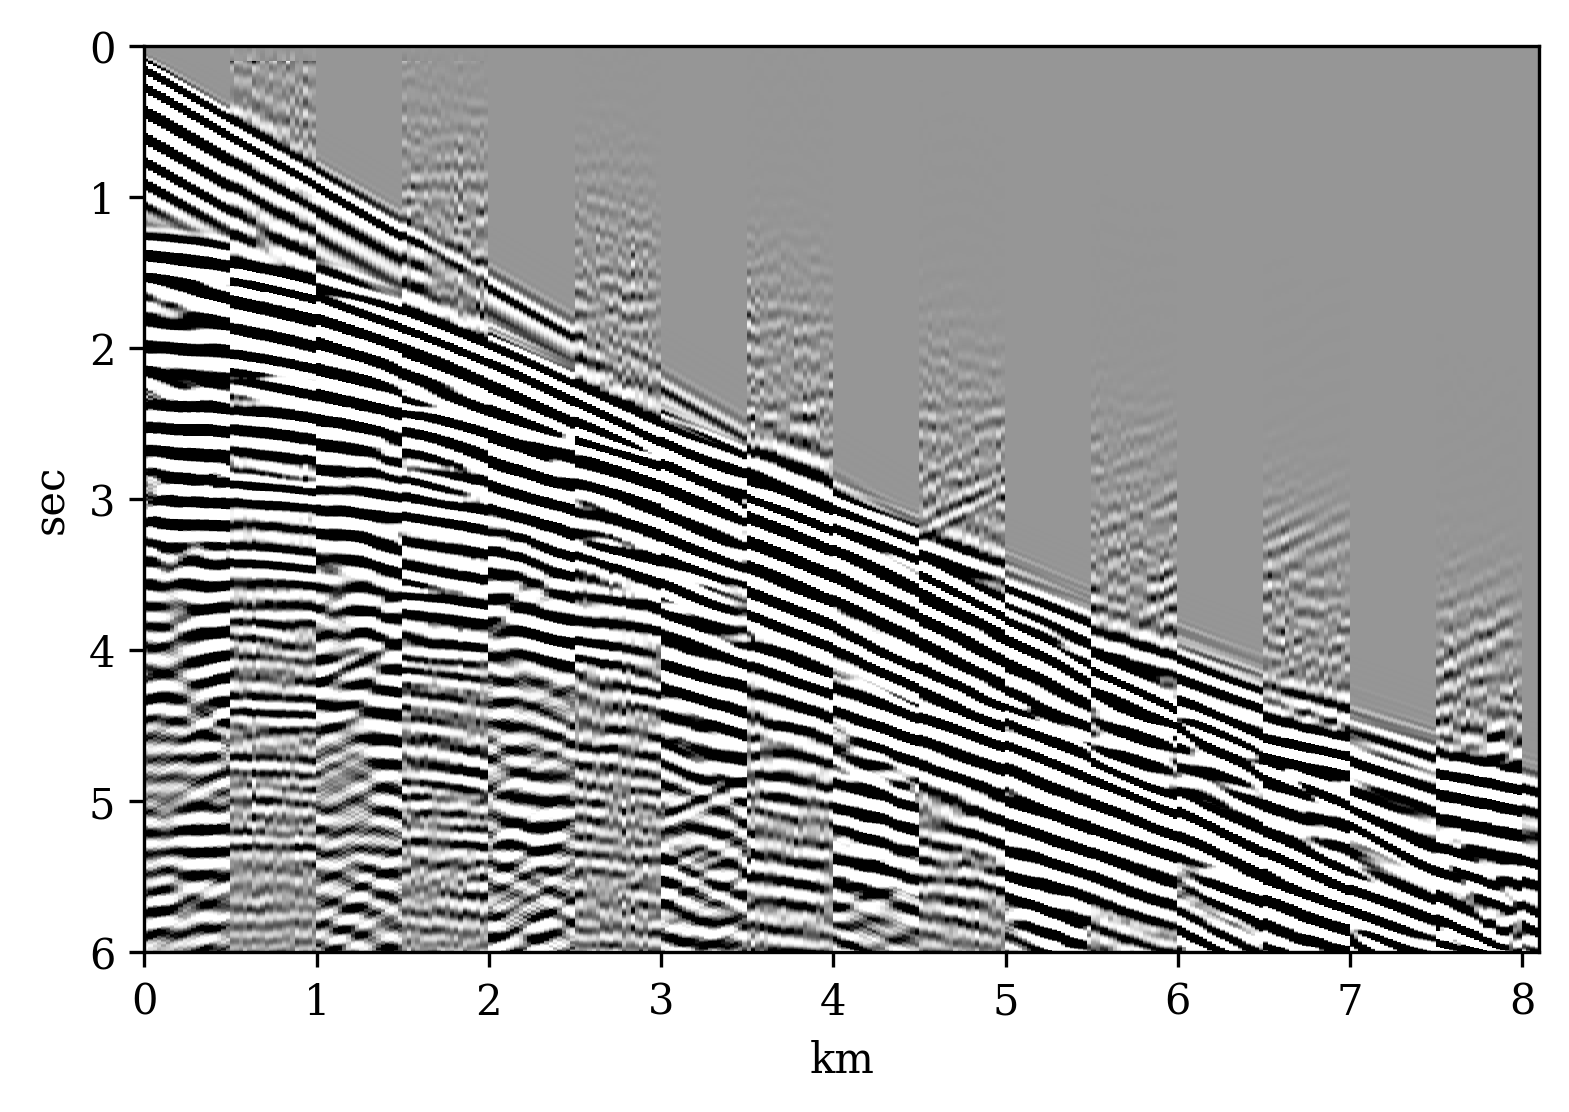

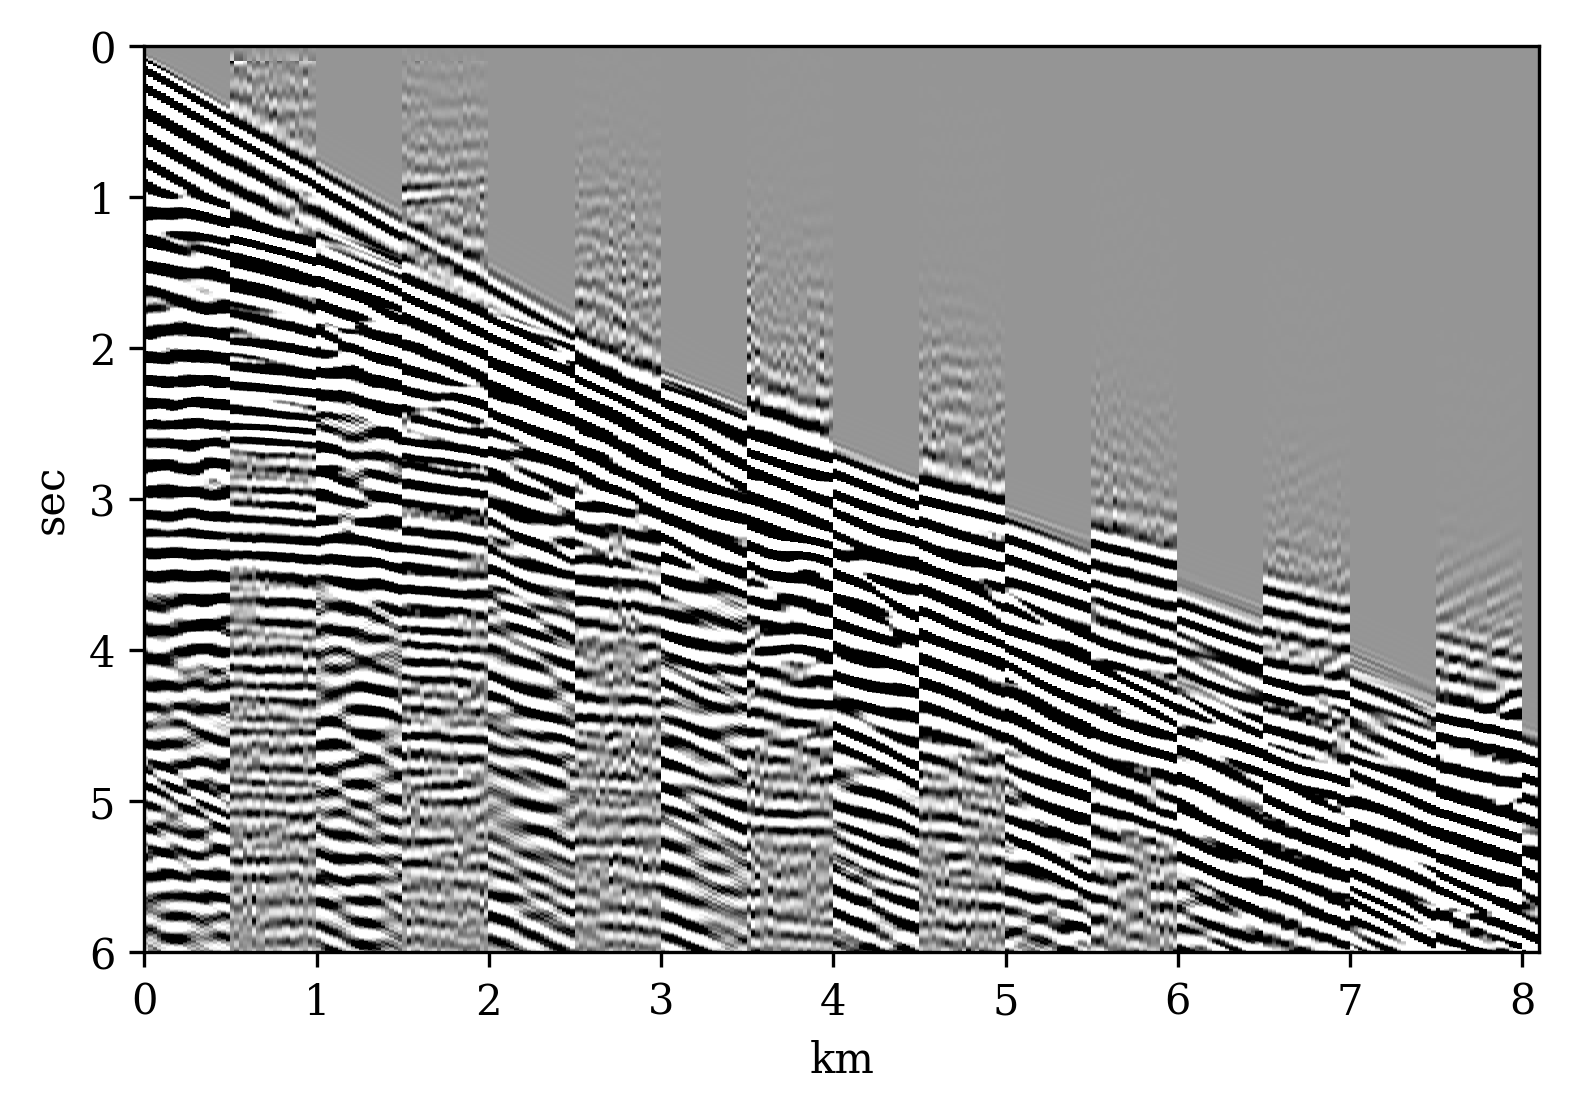

In [5]:
for ishot in [13, 65]:
    print(ishot)
    shot_s = divmax(shots_modelled[ishot])
    shot_f = divmax(shots_field[ishot])
    # shot_f = divmax(shots_field[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=0.002, dx=25)

In [6]:
print(os.getcwd())
print(os.listdir('../fwi/cgg_real_data'))
# shots,filenames=d.get_shots_from_directory('../fwi/cgg_real_data/cnn_13_11/model__cgg_tomo_long1/fld/su',keys=['_p'],return_filenames=True)
shots,filenames=d.get_shots_from_directory('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su',keys=['_p'],return_filenames=True)

# shots=shots[::20]
# filenames=filenames[::20]
shots=shots[0:10]
filenames=filenames[0:10]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check2',file_path=filename.split('/')[-1]+'.png',show=0)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
['fwi_56_strategy_l5multi_cnn_13_special_weight_235_0_model__Marmousi_1d_lin_300_f_z_1', 'cnn_14_1', '23200982_fwi_56_strategy_l5multi_cnn_13_special_weight_235_1_model__cgg_lin_vp_long_300_f_z_stage1_model__cgg_lin_vp_long.out', 'fwi_50_strategy_l5', 'fwi_48_strategy_l5_weight_1500_0', 'fwi_56_strategy_l5multi_cnn_13_special_weight_235_0_model__Marmousi_1d_lin_300_f_z_stage2', 'fwi_56_strategy_l5multi_cnn_13_special_weight_237_0_model__Marmousi_1d_lin_300_f_z_stage1', 'fwi_56_strategy_l2_del_low_weight_147_5hz_0', 'fwi_56_strategy_l5multi_cnn_13_special_weight_237_0_model__Marmousi_1d_lin_300_f_z_2', 'fwi_35_strategy_l5_weight_1351_1', 'fwi_51_strategy_l2_weight_1500_0', 'fwi_47_strategy_l5_weight_1351_0', 'fwi_56_strategy_l5multi_cnn_13_special_weight_236_1_model___cgg_lin_vp_long_300_f_z_stage2', 'fwi_48_strategy_l2_weight_1500_0', 'fwi_50_strategy_l2', 'fwi_56_strategy_l5multi_cnn_13_special_weig

In [7]:
print(os.getcwd())
print(os.listdir('../fwi/cgg_real_data'))
shots,filenames=d.get_shots_from_directory('../fwi/cgg_real_data/cnn_13_11/model__cgg_tomo_long1/fld/su',keys=['_p'],return_filenames=True)
# shots=shots[::20]
# filenames=filenames[::20]
shots=shots[0:10]
filenames=filenames[0:10]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check2',file_path=filename.split('/')[-1]+'.png',show=0)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
['fwi_56_strategy_l5multi_cnn_13_special_weight_235_0_model__Marmousi_1d_lin_300_f_z_1', 'cnn_14_1', '23200982_fwi_56_strategy_l5multi_cnn_13_special_weight_235_1_model__cgg_lin_vp_long_300_f_z_stage1_model__cgg_lin_vp_long.out', 'fwi_50_strategy_l5', 'fwi_48_strategy_l5_weight_1500_0', 'fwi_56_strategy_l5multi_cnn_13_special_weight_235_0_model__Marmousi_1d_lin_300_f_z_stage2', 'fwi_56_strategy_l5multi_cnn_13_special_weight_237_0_model__Marmousi_1d_lin_300_f_z_stage1', 'fwi_56_strategy_l2_del_low_weight_147_5hz_0', 'fwi_56_strategy_l5multi_cnn_13_special_weight_237_0_model__Marmousi_1d_lin_300_f_z_2', 'fwi_35_strategy_l5_weight_1351_1', 'fwi_51_strategy_l2_weight_1500_0', 'fwi_47_strategy_l5_weight_1351_0', 'fwi_56_strategy_l5multi_cnn_13_special_weight_236_1_model___cgg_lin_vp_long_300_f_z_stage2', 'fwi_48_strategy_l2_weight_1500_0', 'fwi_50_strategy_l2', 'fwi_56_strategy_l5multi_cnn_13_special_weig

# Get acquitision details

In [8]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

95/95
Before prep:	(95, 648, 3526)
Data cube:	(95, 324, 3000)
Extended cube:	(95, 324, 3100)
[95, 324, 3050] (95, 324, 3000)
[95, 324, 3150] (95, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	375.0 m
Last source:	14450.0 m
150.0
name:	
x	(95,):	min: 375.0	max: 14475.0
y	(95,):	min: 50.0	max: 50.0
wavelets:	None
z	(95,):	min: 0.0	max: 0.0
nshot:	95
td	(95,):	min: 0.0	max: 0.0
fc	(95,):	min: 8.0	max: 8.0
amp	(95,):	min: 1.0	max: 1.0
angle	(95,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(95,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


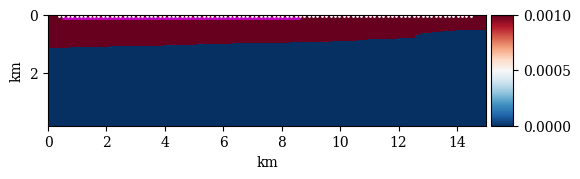

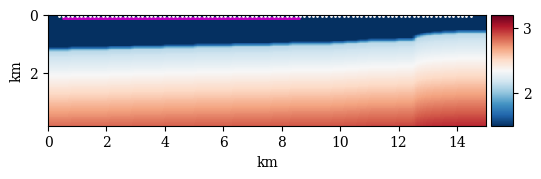

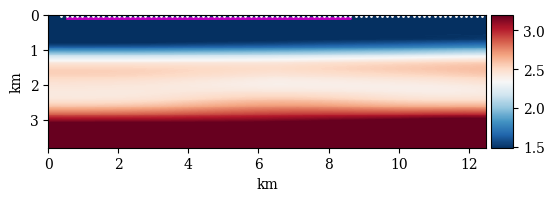

In [9]:
%run ./fwi_shared_check_check_water_bottom.ipynb
# fwi_shared_check_check_water_bottom

In [10]:
root_su_field = os.path.join(d._root_su, 'field/'); 
d.SEIS_FILE_P=root_su_field
print(data_p.shape)
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)
par_mutter = {'k': 7, 'b': -100, 'r': 30}
new_data_p = []
for idat in range(data_p.shape[0]):
    new_data_p.append(np.expand_dims(ld.mutter(data_p[idat, ...], **par_mutter), 0))
new_data_p = np.concatenate(new_data_p)
new_data_p.shape

(95, 324, 3000)
(95, 324, 3000) None


(95, 324, 3000)

## Save field data to a new folder in /su/

In [11]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [13]:
from glob import glob
print(d._root_su)
print(root_su_field)
# copy_su_from_to(d._root_su,root_su_field)

./out_for_pasha/su
./out_for_pasha/su/field/


In [15]:
print(os.getcwd())
shots,filenames=d.get_shots_from_directory(d._root_su,keys=['_p'],return_filenames=True)
shots=shots[::20]
filenames=filenames[::20]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path=filename.split('/')[-1]+'.png',show=0)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
['./out_for_pasha/su/seis_p.su.shot1', './out_for_pasha/su/seis_p.su.shot21', './out_for_pasha/su/seis_p.su.shot41', './out_for_pasha/su/seis_p.su.shot61']
./out_for_pasha/su/seis_p.su.shot1
save to ./pictures_for_check/seis_p.su.shot1.png
./out_for_pasha/su/seis_p.su.shot21
save to ./pictures_for_check/seis_p.su.shot21.png
./out_for_pasha/su/seis_p.su.shot41
save to ./pictures_for_check/seis_p.su.shot41.png
./out_for_pasha/su/seis_p.su.shot61
save to ./pictures_for_check/seis_p.su.shot61.png


# Write field data into created .su files

In [ ]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')
print(fnames)
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = new_data_p[i, :, ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

In [ ]:
def zero_below_freq(dat, fhi, dt, disable=False, reverse=False):
    """ Input zeros into frequency spectrum of data below or above specified frequency.
        by Oleg Ovcharenko, KAUST, 2021
       
    Args:
        dat(np.ndarray): 2D array [noffsets, ntimes]
        fhi(float): threshold frequency, Hz
        dt(float): temporal sampling, sec
        disable(bool): do nothing, return input data
        reverse(bool): when True, set zeros above fhi, otherwise below
    """
    print('Function from cell!!!!!!!!!!!!!!!!!!!!!!!!')
    if disable:
        return dat
    h, w = dat.shape[-2:]
    dat_fx = np.fft.rfft(dat, w)
    ff = np.fft.rfftfreq(dat.shape[-1], d=dt)
    if not reverse:
        where_to_zero = np.where(ff < fhi)[0]
    else:
        where_to_zero = np.where(ff >= fhi)[0]
    dat_fx[..., where_to_zero] = 0. + 0. * 1j
    out = np.fft.irfft(dat_fx, w)
    return out
def filter_seismic_data(path,dt=0.002,corner_frequency=5,fmax=10):
    # d=api.Denise('./',verbose=1)
    d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=0)
    shots,filenames=d.get_shots_from_directory(path,return_filenames=True)
    print('low frequency data corner frequency, ',corner_frequency)
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    counter=0
    delete_low_freqs=True
    for shot,filename in zip(shots,filenames):
        ################    processing stage 1
        filtered_shot=bandpass(shot,fhi=6, dt=dt,order=8, btype='low')
        ################    processing stage 2
        filtered_shot2=bandpass(shot,flo=corner_frequency,dt=dt,order=8,btype='high')
        filtered_shot2_=bandpass(shot,flo=corner_frequency,fhi=6,dt=dt,order=8,btype='band') #for plotting purposes
        ################    processing stage 3
        filtered_shot3=zero_below_freq(filtered_shot2,corner_frequency,dt, disable=False,reverse=False)
        filtered_shot3_=zero_below_freq(filtered_shot2_,corner_frequency,dt, disable=False,reverse=False)
        ################
        plotting_flag=1
        if plotting_flag==1:
            shots_list=[0,22,44,66]
            if counter in shots_list:
                plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='shot_'+str(counter)+'.png',show=0)
                plot_shot(filtered_shot2,pclip=0.05,folder_path='./pictures_for_check',file_path='shot'+str(counter)+'_stage2.png',show=0)
                freqs,ps=plot_spectrum(shot,dt,fmax=fmax,folder_path='./pictures_for_check',file_path='spectrum_'+str(counter)+'_original.png')
                freqs,ps=plot_spectrum(filtered_shot2,dt,fmax=fmax,folder_path='./pictures_for_check',file_path='spectrum_'+str(counter)+'stage2.png')
        ################    chosen processing    
        with segyio.su.open(filename,"r+",endian='little',ignore_geometry=True) as dst:
            if delete_low_freqs==False: dst.trace=filtered_shot2    #only high-pass filtered data
            else:   dst.trace=filtered_shot3    #high-pass filtered data, frequencies belof Fc are zeroed out
        # shot_read,read_filename=d.get_shots_from_datadir(keys=[filename],return_filenames=True); shot_read=shot_read[0]
        counter=counter+1
    return None


print(os.getcwd())
print(d.DT)
su_field_path1 = os.path.join(os.getcwd(),'su_field_high_pass_5_hz/')
su_field_path2 = os.path.join(os.getcwd(),'su_field/')

api._cmd('rm -r '+su_field_path1)
copy_su_from_to(root_su_field,su_field_path1)
filter_seismic_data(su_field_path1,dt=0.002,corner_frequency=5,fmax=10)

api._cmd('rm -r '+su_field_path2)
copy_su_from_to(root_su_field,su_field_path2)

In [ ]:
# shots,filenames=d.get_shots_from_directory(su_field_path2,keys=['_p'],return_filenames=True)
# for shot in shots:
#     print(shot.shape)
shots,filenames=d.get_shots_from_directory(su_field_path1,keys=['_p'],return_filenames=True)
for shot in shots:
    print(shot.shape)

# shots=shots[::10]
# filenames=filenames[::10]
# print(filenames)
# for shot,filename in zip(shots,filenames):
#     print(filename)
#     plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='su_field_path2_'+filename.split('/')[-1]+'.png',show=0)

# shots,filenames=d.get_shots_from_directory(su_field_path1,keys=['_p'],return_filenames=True)
# shots=shots[::20]
# filenames=filenames[::20]
# print(filenames)
# for shot,filename in zip(shots,filenames):
#     print(filename)
#     # plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='su_field_path1_'+filename.split('/')[-1]+'.png',show=0)
#     freqs,ps=plot_spectrum(shot,0.002,fmax=10,folder_path='./pictures_for_check',file_path='su_field_path1_'+'spectrum_'+filename.split('/')[-1]+'stage2.png')

In [ ]:
d.save_folder = os.path.join(root_fwi,'fwi_full_spectrum','fld')
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [ ]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [ ]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [ ]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
par_forward = {'run_command': 'mpirun -np 30', 'disable': False}
print(par_forward)

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.verbose=1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
def divmax(x): return x / np.max(np.abs(x))
d.verbose = 0    # don't show redundant print outs
if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in [19, 62]:
    print(ishot)
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)